# The Nobelizer

## by Catalin Vasii

I thoght a little tool to get a Nobel Prize in lit would be useful. This notebook is a recurrent neural network in the style of [Jeremy Howard's fast.ai](http://www.fast.ai/) that has been trained onall Bob Dylan song lyrics to predict the next character for each given sequence of characters.

In [24]:
%matplotlib inline
import numpy as np

from keras.models import Sequential

from keras.layers import Dense, Activation, Embedding, Dropout
from keras.layers import TimeDistributed, Activation, LSTM
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from numpy.random import choice

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

## 1.  Data Preparation

In [25]:
path = 'dylansongs.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 563887


In [26]:
!tail {path} -n23

Flowers on the hillside blooming crazy
Crickets talking back and forth in rhyme
Blue river running slow and lazy
I could stay with you forever and never realize the time

Situations have ended sad
Relationships have all been bad
Mine have been like Verlaine's and Rimbaud's
But there's no way I can compare
All them scenes to this affair,
You're gonna make me lonesome when you go

You're gonna make me wonder what I'm doing
Staying far behind without you
You're gonna make me wonder what I'm saying
You're gonna make me give myself a good talking to

I'll look for you in old Honolulu
San Francisco or Ashtabula
You're gonna have to leave me now I know
But I'll see you in the sky above
In the tall grass in the ones I love
You're gonna make me lonesome when you go/nNone/nNone/n

In [27]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 58


In [28]:
chars.insert(0, "\0")

In [29]:
''.join(chars[1:-6])

'\n !"\'(),-./0123456789:;?[]abcdefghijklmnopqrstuvwxy'

We are constructing two dictionaries, mapping characters to numbers (index in the text) and conversely

In [30]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [31]:
idx = [char_indices[c] for c in text]

In [32]:
idx[:10]

[46, 31, 40, 2, 46, 34, 41, 47, 45, 27]

In [33]:
''.join(indices_char[i] for i in idx[:70])

"ten thousand men on a hill,\nsome of 'm goin' down, some of 'm gonna ge"

## 2. Model Creation

In [34]:
maxlen = 36
sentences = []
next_chars = []
for i in range(0, len(idx) - maxlen+1):
    sentences.append(idx[i: i + maxlen])
    next_chars.append(idx[i+1: i+maxlen+1])
print('nb sequences:', len(sentences))

nb sequences: 563852


In [35]:
print('first two sentences are: ' ,sentences[:2])
print('first two next chars are: ' ,next_chars[:2])

[[46, 31, 40, 2, 46, 34, 41, 47, 45, 27, 40, 30, 2, 39, 31, 40, 2, 41, 40, 2, 27, 2, 34, 35, 38, 38, 8, 1, 45, 41, 39, 31, 2, 41, 32, 2], [31, 40, 2, 46, 34, 41, 47, 45, 27, 40, 30, 2, 39, 31, 40, 2, 41, 40, 2, 27, 2, 34, 35, 38, 38, 8, 1, 45, 41, 39, 31, 2, 41, 32, 2, 5]]
[[31, 40, 2, 46, 34, 41, 47, 45, 27, 40, 30, 2, 39, 31, 40, 2, 41, 40, 2, 27, 2, 34, 35, 38, 38, 8, 1, 45, 41, 39, 31, 2, 41, 32, 2, 5], [40, 2, 46, 34, 41, 47, 45, 27, 40, 30, 2, 39, 31, 40, 2, 41, 40, 2, 27, 2, 34, 35, 38, 38, 8, 1, 45, 41, 39, 31, 2, 41, 32, 2, 5, 39]]


In [36]:
sentences = np.concatenate([[np.array(o)] for o in sentences[:-2]])
next_chars = np.concatenate([[np.array(o)] for o in next_chars[:-2]])

In [38]:
sentences.shape, next_chars.shape

((563850, 36), (563850, 36))

It is Jeremy Howard's approach to use embeddings instead of one hot encodings. We set the number of latent factor to 24

In [39]:
n_fac = 24

Long Short Time Memory

Keras has three types of recurrent layers: LSTM, GRU and SimpleRNN. The first two are more complex, I will only put a scheme of a LSTM, i.e. Long Short Time Memory: 

![](Long_Short_Term_Memory.png)

In [40]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=maxlen),
        BatchNormalization(),    
        LSTM(512, input_dim=n_fac,return_sequences=True, dropout_U=0.2, dropout_W=0.2,
             consume_less='gpu'),
        Dropout(0.2),
        LSTM(512, return_sequences=True, dropout_U=0.2, dropout_W=0.2,
             consume_less='gpu'),
        Dropout(0.2),
        TimeDistributed(Dense(vocab_size)),
        Activation('softmax')
    ])    

In [41]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

Graphically, the network looks like below, but keep in mind that each of the two recurrent layers look like in the above picture.

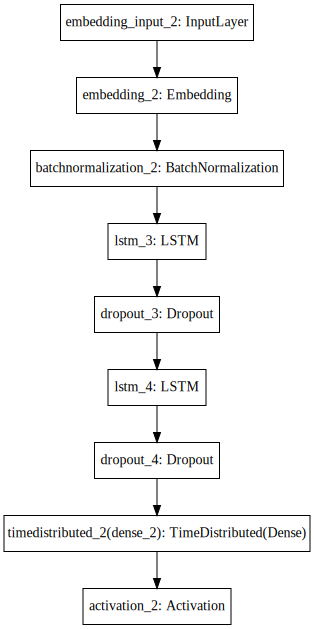

In [42]:

SVG(model_to_dot(model).create(prog='dot', format='svg'))

We ca have a more detailed description of the model. There are more than 3 milion parameters.

In [43]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 36, 24)        1392        embedding_input_2[0][0]          
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 36, 24)        96          embedding_2[0][0]                
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 36, 512)       1099776     batchnormalization_2[0][0]       
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 36, 512)       0           lstm_3[0][0]                     
___________________________________________________________________________________________

### 3. Fitting the model and generating the poetry

We need a function for the predictions. Starting with a _seed string_, it will predict the next character. Then, the seed together with the next character becomes the new seed and process is repeted.

In [44]:
def print_example():
    seed_string="i feel i'm knockin' on heaven's door"
    for i in range(500):
        x=np.array([char_indices[c] for c in seed_string[-36:]])[np.newaxis,:]
        preds = model.predict(x, verbose=0)[0][-1]
        preds = preds/np.sum(preds)
        next_char = choice(chars, p=preds)
        seed_string = seed_string + next_char
    print(seed_string)

In [45]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=1, verbose=2)

Epoch 1/1
544s - loss: 1.4147


In [46]:
print_example()

i feel i'm knockin' on heaven's door
and we dreamt everything you don't know what he's in

everybody's got no braind from shack
it's so long with you.

who's gonna let it down to bove,
your picture that you ain't got up they flamed out

maybe i was plain: i feel that will remember what's mine to hell

oh, baby, please! he will haunt me by

well, i got the floorson of the locusts
shame up around your teeth, glowing for the summertime,
i'm on the street when it was closer, the middle of the ground
the walls shall be staylight in the


In [47]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=1, verbose =2)

Epoch 1/1
539s - loss: 1.2449


In [48]:
print_example()

i feel i'm knockin' on heaven's door
he stood seen them cold
i was up to me you have heard the glass

my conscience did up yet
and i cry alone at the police hold of the sweet
and his tune did hear?
yes, but i'm in the lay, like sugar as a couple
and i'm going
i'm so glad
ain't made of the mornin' like you'd have my heart/nnone/npreacher in a hill for the red roof, stay
we shall rush a soriet perceive headed
and she began to have heard it too much hounds in her house away
you have got a highway of the children trying to get to be s


In [49]:
model.optimizer.lr=0.001

In [50]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=2, verbose=2)

Epoch 1/2
542s - loss: 1.2083
Epoch 2/2
544s - loss: 1.1857


In [51]:
print_example()

i feel i'm knockin' on heaven's door
knock, knockin' on heaven's door
knock, knockin' on heaven's shootin' stranger
the cat's in the well, we were born in time.

i was talkin' to the bundon and where must be
in a storm"/nnone/nout, the last way, i can’t even remember what she did and knocked out and he just wanted to do what they'll be flyin'
but i figured her eyes are expecting the street.

he's the rain hates have heard of rules. he tried to do to stay behind

the meadows well-many auserums
don't let her defend to die

i know to


In [52]:
model.optimizer.lr=0.0001

In [ ]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64,
          nb_epoch=2, verbose=2)

In [ ]:
print_example()

In [ ]:
model.optimizer.lr=0.00001

In [ ]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=8, verbose=2)

In [ ]:
print_example()

In [ ]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=4, verbose=2)

In [ ]:
print_example()

In [ ]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=4, verbose=2)

In [ ]:
print_example()

In [ ]:
model.fit(sentences, np.expand_dims(next_chars,-1), batch_size=64, 
          nb_epoch=42, verbose=2)

In [ ]:
print_example()

In [ ]:
print_example()

In [ ]:
print_example()

In [ ]:
seed_string="i feel i'm knockin' on heaven's door"
for i in range(2000):
    x=np.array([char_indices[c] for c in seed_string[-36:]])[np.newaxis,:]
    preds = model.predict(x, verbose=0)[0][-1]
    preds = preds/np.sum(preds)
    next_char = choice(chars, p=preds)
    seed_string = seed_string + next_char
f = open('generatedtext.txt','w')
f.write(seed_string)
f.close()